In [ ]:
Name = 'Parsa Ghezelbash'
STID = 401110437

In [14]:
import numpy as np



import matplotlib.pyplot as plt







import torch



import torch.nn as nn



import torch.nn.functional as F



import torch.optim as optim



from torch.utils.data import Subset



from torch.utils.data import DataLoader



from torch.utils.data import random_split







import torchvision



import torchvision.transforms as transforms







from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay







import time







import importlib



import utils







importlib.reload(utils)



from utils.utils import (



    accuracy,



    train,



    combined_train,



    test,



    plot_acc,



    plot_loss,



    plot_confusion_matrix,



    save_model,



    get_feature_maps,



    visualize_feature_maps,



    plot_images,



    plot_feature_maps,



)

# Loading CIFAR-10 Dataset + Preprocess


In [15]:
class OneHotEncode:



    def __init__(self, num_classes):



        self.num_classes = num_classes







    def __call__(self, label):



        return F.one_hot(torch.tensor(label), num_classes=self.num_classes).float()

In [16]:
train_size = 50000



val_size = 10000



test_size = 10000



mean = [0.485, 0.456, 0.406]



std = [0.229, 0.224, 0.225]



num_classes = 10







torch.manual_seed(13)



np.random.seed(13)







transform = transforms.Compose(



    [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]



)







label_transform = OneHotEncode(num_classes=num_classes)







train_dataset = torchvision.datasets.CIFAR10(



    root="./data",



    train=True,



    download=True,



    transform=transform,



    target_transform=label_transform,



)







test_dataset = torchvision.datasets.CIFAR10(



    root="./data",



    train=False,



    download=True,



    transform=transform,



    target_transform=label_transform,



)







train_subset, val_subset = random_split(



    train_dataset, [train_size - val_size, val_size]



)



test_subset, _ = random_split(test_dataset, [test_size, len(test_dataset) - test_size])

Files already downloaded and verified
Files already downloaded and verified


In [17]:
classes = train_dataset.classes



print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Dataset Preview


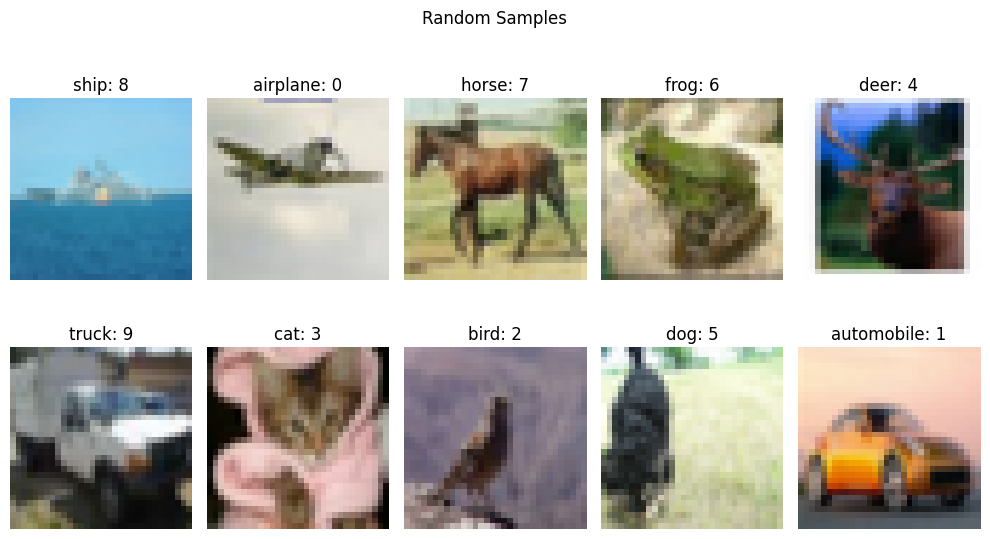

In [18]:
samples = {}







for image, label in train_subset:



    label = torch.argmax(label).item()



    if label not in samples:



        samples[f"{classes[label]}: {label}"] = image



    if len(samples) == len(classes):



        break







plot_images(list(samples.values()), mean, std, list(samples.keys()), "Random Samples")

## Data Loaders

In [19]:
train_loader = DataLoader(



    train_subset,



    batch_size=32,



    shuffle=True,



    num_workers=4,



    pin_memory=True,



    persistent_workers=True,



)



val_loader = DataLoader(



    val_subset,



    batch_size=32,



    shuffle=True,



    num_workers=4,



    pin_memory=True,



    persistent_workers=True,



)



test_loader = DataLoader(



    test_subset,



    batch_size=32,



    shuffle=True,



    num_workers=4,



    pin_memory=True,



    persistent_workers=True,



)

# Training Model


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



print(f"device: {device.type}")

device: cuda


In [21]:
class BaselineModel(nn.Module):



    def __init__(self):



        super(BaselineModel, self).__init__()







        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)



        self.relu = nn.ReLU()



        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)



        self.flatten = nn.Flatten()



        self.fc = nn.Linear(64 * 14 * 14, 10)







    def forward(self, x):



        x = self.conv1(x)



        x = self.relu(x)



        x = self.maxpool(x)



        x = self.flatten(x)



        x = self.fc(x)



        return x











baseline_model = BaselineModel().to(device)



criterion = nn.CrossEntropyLoss()



optimizer = optim.SGD(params=baseline_model.parameters())

In [22]:
start_time = time.time()



epochs = 30







train_losses, train_accuracies, validation_losses, validation_accuracies = train(



    model=baseline_model,



    train_loader=train_loader,



    val_loader=val_loader,



    optimizer=optimizer,



    criterion=criterion,



    device=device,



    epochs=epochs,



    log=True,



)







end_time = time.time()



print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 5/30, Train loss: 41.158, Train acc: 0.559, Val loss: 41.497, Val acc: 0.55
Epoch 10/30, Train loss: 35.382, Train acc: 0.622, Val loss: 37.464, Val acc: 0.592
Epoch 15/30, Train loss: 32.084, Train acc: 0.659, Val loss: 35.334, Val acc: 0.616
Epoch 20/30, Train loss: 29.842, Train acc: 0.684, Val loss: 34.432, Val acc: 0.628
Epoch 25/30, Train loss: 28.189, Train acc: 0.702, Val loss: 33.553, Val acc: 0.639
Epoch 30/30, Train loss: 26.851, Train acc: 0.717, Val loss: 33.011, Val acc: 0.645
time: 247.9 seconds


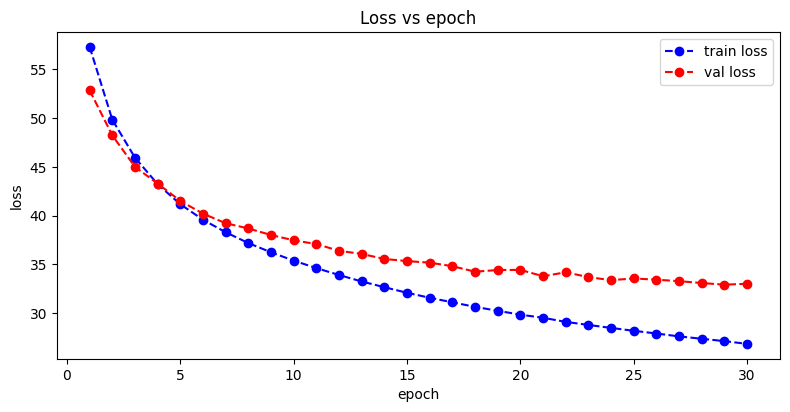

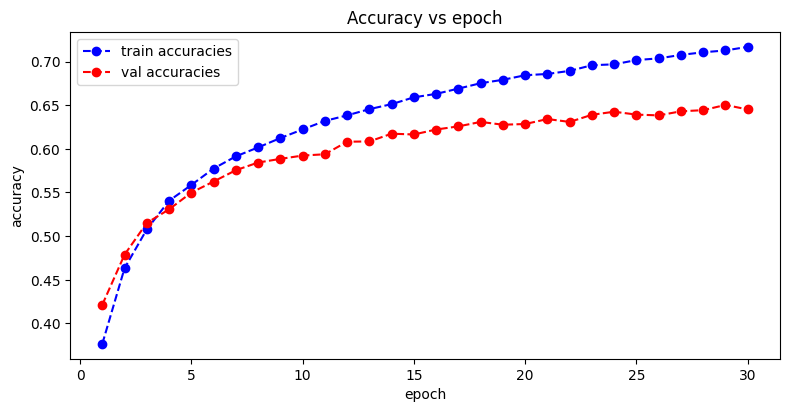

In [23]:
plot_loss(train_losses, validation_losses, epochs=epochs)



plot_acc(train_accuracies, validation_accuracies, epochs=epochs)

In [24]:
save_model(baseline_model, "./baseline.pth")

model saved to ./baseline.pth successfully!


# Improving Model


In [25]:
class ImprovedModel(nn.Module):



    def __init__(self):



        super(ImprovedModel, self).__init__()







        self.relu1 = nn.ReLU()



        self.relu2 = nn.ReLU()



        self.relu3 = nn.ReLU()







        # 3 * 32 * 32 -> 64 * 30 * 30



        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)



        # 64 * 29 * 29 -> 128 * 27 * 27



        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)



        # 128 * 26 * 26 -> 256 * 24 * 24



        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)



        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=1)



        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=1)



        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=1)



        self.flatten = nn.Flatten()



        self.fc = nn.Linear(256 * 23 * 23, 10)







    def forward(self, x):



        x = self.conv1(x)



        x = self.relu1(x)



        x = self.maxpool1(x)



        x = self.conv2(x)



        x = self.relu2(x)



        x = self.maxpool2(x)



        x = self.conv3(x)



        x = self.relu3(x)



        x = self.maxpool3(x)



        x = self.flatten(x)



        x = self.fc(x)



        return x











improved_model = ImprovedModel().to(device)



criterion = nn.CrossEntropyLoss()



optimizer = optim.SGD(params=improved_model.parameters())

In [26]:
start_time = time.time()



epochs = 30







train_losses, train_accuracies, validation_losses, validation_accuracies = train(



    model=improved_model,



    train_loader=train_loader,



    val_loader=val_loader,



    optimizer=optimizer,



    criterion=criterion,



    device=device,



    epochs=epochs,



    log=True,



)







end_time = time.time()



print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 5/30, Train loss: 37.54, Train acc: 0.593, Val loss: 37.425, Val acc: 0.592
Epoch 10/30, Train loss: 30.61, Train acc: 0.672, Val loss: 32.394, Val acc: 0.649
Epoch 15/30, Train loss: 26.293, Train acc: 0.721, Val loss: 29.727, Val acc: 0.686
Epoch 20/30, Train loss: 22.667, Train acc: 0.761, Val loss: 28.694, Val acc: 0.7
Epoch 25/30, Train loss: 19.568, Train acc: 0.792, Val loss: 27.449, Val acc: 0.712
Epoch 30/30, Train loss: 16.702, Train acc: 0.826, Val loss: 27.796, Val acc: 0.716
time: 335.1 seconds


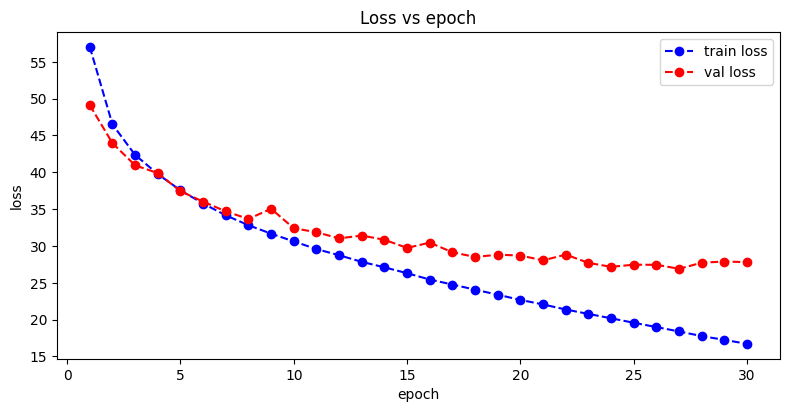

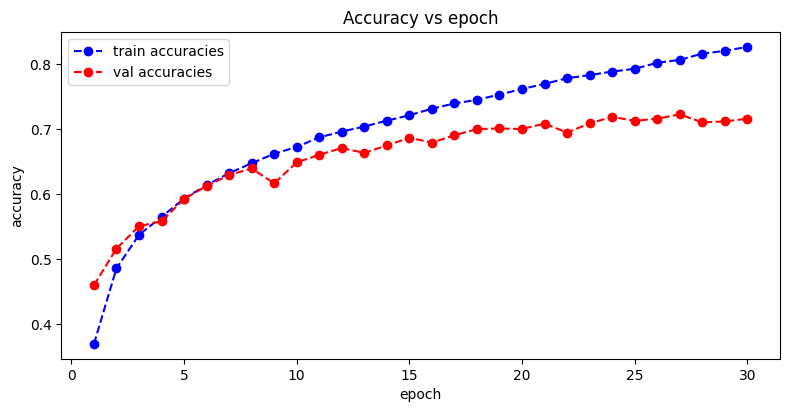

In [27]:
plot_loss(train_losses, validation_losses, epochs=epochs)



plot_acc(train_accuracies, validation_accuracies, epochs=epochs)

In [28]:
save_model(improved_model, "./improvedmodel.pth")

model saved to ./improvedmodel.pth successfully!


# Adding Batch Normalization


In [33]:
class BnModel(nn.Module):



    def __init__(self):



        super(BnModel, self).__init__()







        self.relu1 = nn.ReLU()



        self.relu2 = nn.ReLU()



        self.relu3 = nn.ReLU()







        # 3 * 32 * 32 -> 64 * 30 * 30



        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)



        self.bn1 = nn.BatchNorm2d(64)



        # 64 * 29 * 29 -> 128 * 27 * 27



        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)



        self.bn2 = nn.BatchNorm2d(128)



        # 128 * 26 * 26 -> 256 * 24 * 24



        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)



        self.bn3 = nn.BatchNorm2d(256)



        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=1)



        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=1)



        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=1)



        self.flatten = nn.Flatten()



        self.fc = nn.Linear(256 * 23 * 23, 10)







    def forward(self, x):



        x = self.conv1(x)



        x = self.bn1(x)



        x = self.relu1(x)



        x = self.maxpool1(x)



        x = self.conv2(x)



        x = self.bn2(x)



        x = self.relu2(x)



        x = self.maxpool2(x)



        x = self.conv3(x)



        x = self.bn3(x)



        x = self.relu3(x)



        x = self.maxpool3(x)



        x = self.flatten(x)



        x = self.fc(x)



        return x











bn_model = BnModel().to(device)



criterion = nn.CrossEntropyLoss()



optimizer = optim.SGD(params=bn_model.parameters())

In [34]:
start_time = time.time()



epochs = 30







train_losses, train_accuracies, validation_losses, validation_accuracies = train(



    model=bn_model,



    train_loader=train_loader,



    val_loader=val_loader,



    optimizer=optimizer,



    criterion=criterion,



    device=device,



    epochs=epochs,



    log=True,



)







end_time = time.time()



print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 5/30, Train loss: 28.909, Train acc: 0.711, Val loss: 38.944, Val acc: 0.637
Epoch 10/30, Train loss: 15.531, Train acc: 0.831, Val loss: 40.475, Val acc: 0.659
Epoch 15/30, Train loss: 7.907, Train acc: 0.918, Val loss: 32.539, Val acc: 0.72
Epoch 20/30, Train loss: 3.852, Train acc: 0.971, Val loss: 30.87, Val acc: 0.733
Epoch 25/30, Train loss: 2.033, Train acc: 0.992, Val loss: 31.361, Val acc: 0.735
Epoch 30/30, Train loss: 1.271, Train acc: 0.997, Val loss: 33.447, Val acc: 0.728
time: 360.96 seconds


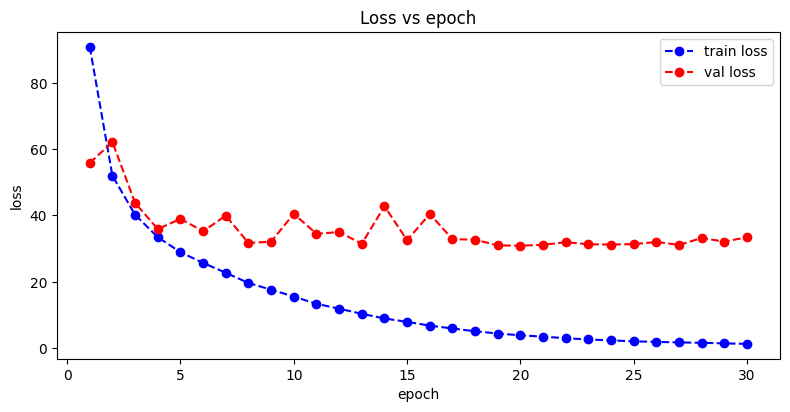

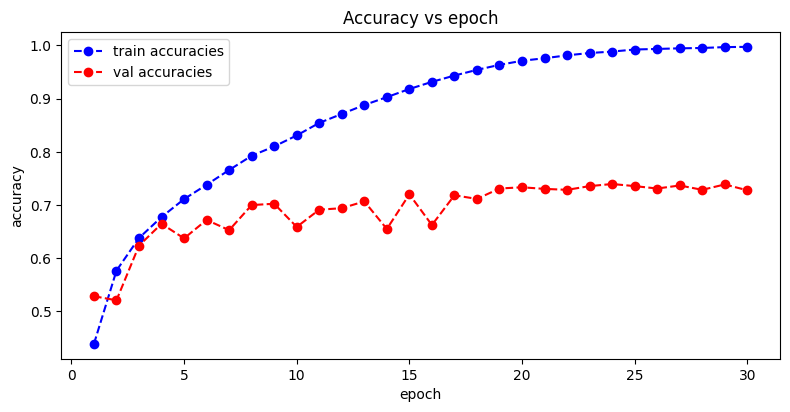

In [35]:
plot_loss(train_losses, validation_losses, epochs=epochs)



plot_acc(train_accuracies, validation_accuracies, epochs=epochs)

Adding Batch Normalization after each layer of Convolution makes optimization landscape smoother which helps faster convergance and increases accuracy in the same number of epochs.

In addition Batch Normalization helps regularization and makes the model learn differences between features.

In [36]:
save_model(bn_model, "./bnmodel.pth")

model saved to ./bnmodel.pth successfully!


# Adding Dropout


In [42]:
class DoModel(nn.Module):



    def __init__(self):



        super(DoModel, self).__init__()







        self.relu1 = nn.ReLU()



        self.relu2 = nn.ReLU()



        self.relu3 = nn.ReLU()







        # 3 * 32 * 32 -> 64 * 30 * 30



        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)



        self.bn1 = nn.BatchNorm2d(64)



        # 64 * 29 * 29 -> 128 * 27 * 27



        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)



        self.bn2 = nn.BatchNorm2d(128)



        # 128 * 26 * 26 -> 256 * 24 * 24



        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)



        self.bn3 = nn.BatchNorm2d(256)



        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=1)



        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=1)



        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=1)



        self.flatten = nn.Flatten()



        self.dropout = nn.Dropout(p=0.2, inplace=False)



        self.fc = nn.Linear(256 * 23 * 23, 10)







    def forward(self, x):



        x = self.conv1(x)



        x = self.bn1(x)



        x = self.relu1(x)



        x = self.maxpool1(x)



        x = self.conv2(x)



        x = self.bn2(x)



        x = self.relu2(x)



        x = self.maxpool2(x)



        x = self.conv3(x)



        x = self.bn3(x)



        x = self.relu3(x)



        x = self.maxpool3(x)



        x = self.flatten(x)



        x = self.dropout(x)



        x = self.fc(x)



        return x











do_model = DoModel().to(device)



criterion = nn.CrossEntropyLoss()



optimizer = optim.SGD(params=do_model.parameters())

In [43]:
start_time = time.time()



epochs = 30







train_losses, train_accuracies, validation_losses, validation_accuracies = train(



    model=do_model,



    train_loader=train_loader,



    val_loader=val_loader,



    optimizer=optimizer,



    criterion=criterion,



    device=device,



    epochs=epochs,



    log=True,



)







end_time = time.time()



print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 5/30, Train loss: 30.373, Train acc: 0.703, Val loss: 38.855, Val acc: 0.641
Epoch 10/30, Train loss: 17.563, Train acc: 0.812, Val loss: 32.468, Val acc: 0.701
Epoch 15/30, Train loss: 10.392, Train acc: 0.885, Val loss: 32.919, Val acc: 0.718
Epoch 20/30, Train loss: 6.303, Train acc: 0.934, Val loss: 31.797, Val acc: 0.726
Epoch 25/30, Train loss: 3.933, Train acc: 0.964, Val loss: 33.814, Val acc: 0.723
Epoch 30/30, Train loss: 2.605, Train acc: 0.98, Val loss: 33.74, Val acc: 0.733
time: 365.17 seconds


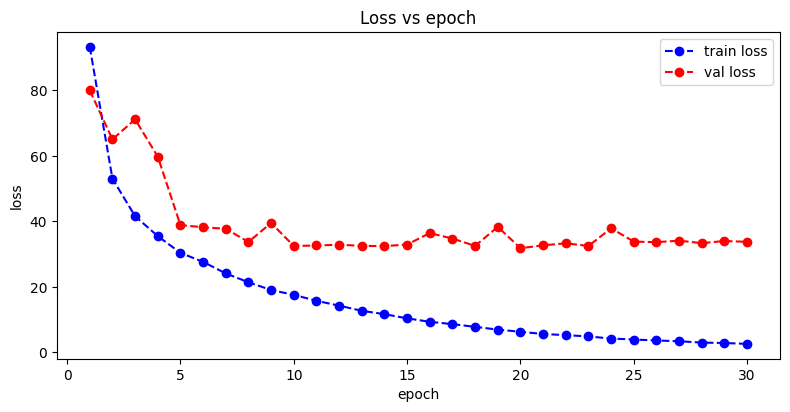

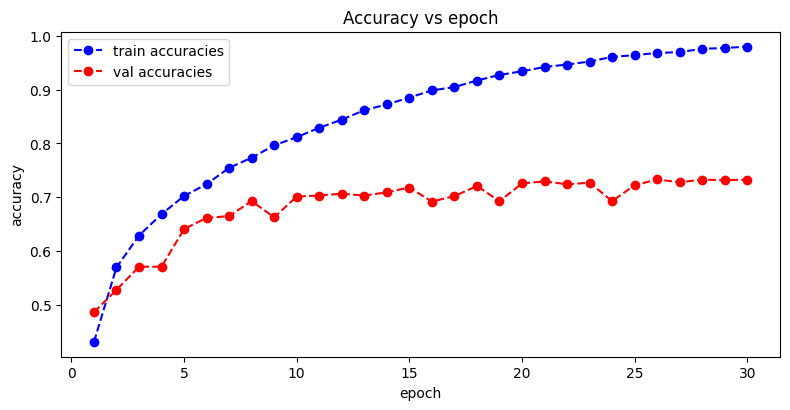

In [44]:
plot_loss(train_losses, validation_losses, epochs=epochs)



plot_acc(train_accuracies, validation_accuracies, epochs=epochs)

Dropout reduces overfitting by randomly selecting perceptorns in Linear layer and avoids being biased towards specific features and increases accuracy.

In [45]:
save_model(bn_model, "./domodel.pth")

model saved to ./domodel.pth successfully!


# Test and Confusion Matrix


baseline model:
loss= 32.737, accuracy= 0.649


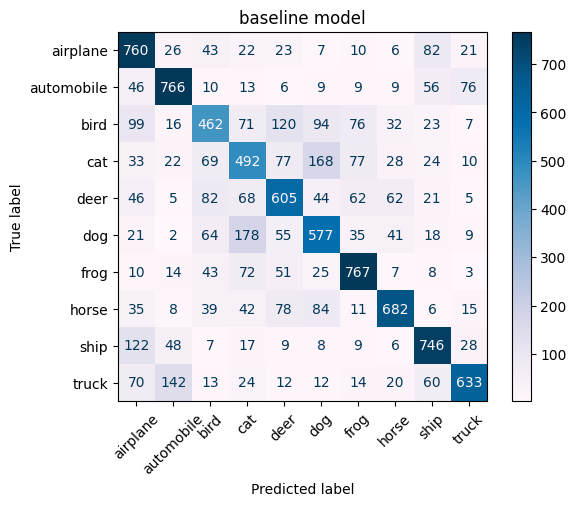

improved model:
loss= 27.251, accuracy= 0.714


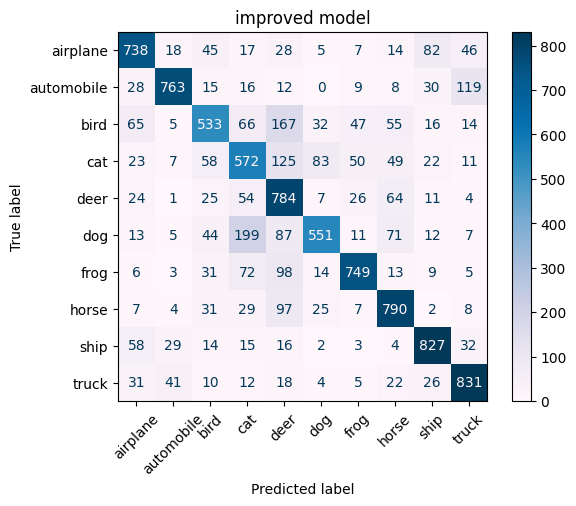

batch normalization model
loss= 32.903, accuracy= 0.726


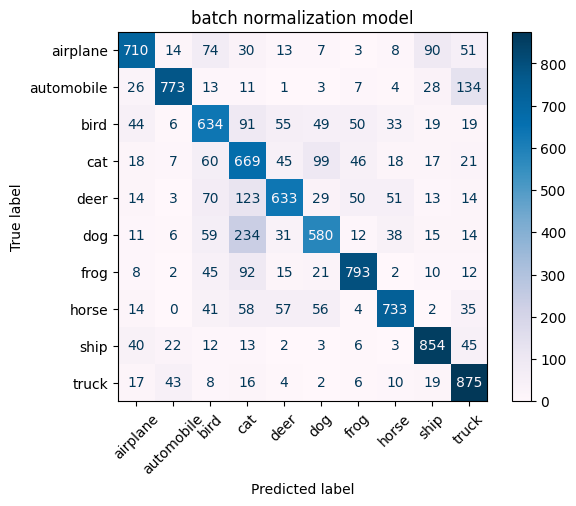

dropout model
loss= 33.664, accuracy= 0.734


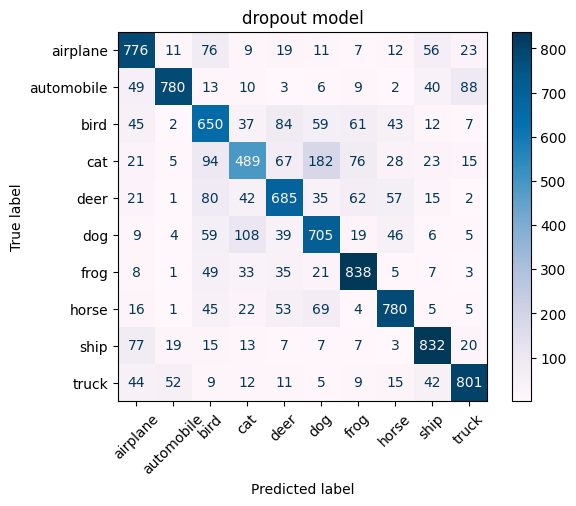

In [46]:
base_loss, base_accuracy, base_preds, base_labels = test(



    model=baseline_model, test_loader=test_loader, criterion=criterion, device=device



)



print("baseline model:")



print(f"loss= {np.round(base_loss, 3)}, accuracy= {np.round(base_accuracy, 3)}")



plot_confusion_matrix(



    base_labels, base_preds, class_names=classes, title="baseline model"



)











improved_loss, improved_accuracy, improved_preds, improved_labels = test(



    model=improved_model, test_loader=test_loader, criterion=criterion, device=device



)



print("improved model:")



print(f"loss= {np.round(improved_loss, 3)}, accuracy= {np.round(improved_accuracy, 3)}")



plot_confusion_matrix(



    improved_labels, improved_preds, class_names=classes, title="improved model"



)











bn_loss, bn_accuracy, bn_preds, bn_labels = test(



    model=bn_model, test_loader=test_loader, criterion=criterion, device=device



)



print("batch normalization model")



print(f"loss= {np.round(bn_loss, 3)}, accuracy= {np.round(bn_accuracy, 3)}")



plot_confusion_matrix(



    bn_labels, bn_preds, class_names=classes, title="batch normalization model"



)











do_loss, do_accuracy, do_preds, do_labels = test(



    model=do_model, test_loader=test_loader, criterion=criterion, device=device



)



print("dropout model")



print(f"loss= {np.round(do_loss, 3)}, accuracy= {np.round(do_accuracy, 3)}")



plot_confusion_matrix(do_labels, do_preds, class_names=classes, title="dropout model")